# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [212]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import tensorflow as tf

from tensorflow.contrib.layers import flatten
#from pipeline import NeuralNetwork, make_adam, Session, build_pipeline

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [213]:
TRAIN_IMAGE_DIR = 'GTSRB\\Final_Training\\Images'

dfs = []
#open csv file
for train_file in glob.glob(os.path.join(TRAIN_IMAGE_DIR, '*/GT-*.csv')):
    folder = train_file.split('\\')[3]
    df = pd.read_csv(train_file, sep=';')
    df['Filename'] = df['Filename'].apply(lambda x: os.path.join(TRAIN_IMAGE_DIR, folder, x))
    dfs.append(df)

In [214]:
train_df = pd.concat(dfs, ignore_index=True)
train_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,GTSRB\Final_Training\Images\00000\00000_00000.ppm,29,30,5,6,24,25,0
1,GTSRB\Final_Training\Images\00000\00000_00001.ppm,30,30,5,5,25,25,0
2,GTSRB\Final_Training\Images\00000\00000_00002.ppm,30,30,5,5,25,25,0
3,GTSRB\Final_Training\Images\00000\00000_00003.ppm,31,31,5,5,26,26,0
4,GTSRB\Final_Training\Images\00000\00000_00004.ppm,30,32,5,6,25,26,0


In [215]:
N_CLASSES = np.unique(train_df['ClassId']).size  # keep this for later

print("Number of training images : {:>5}".format(train_df.shape[0]))
print("Number of classes         : {:>5}".format(N_CLASSES))

Number of training images : 39209
Number of classes         :    43


In [216]:
def show_class_distribution(classIDs, title):
    """
    Plot the traffic sign class distribution
    """
    plt.figure(figsize=(15, 5))
    plt.title('Class ID distribution for {}'.format(title))
    plt.hist(classIDs, bins=N_CLASSES)
    plt.show()

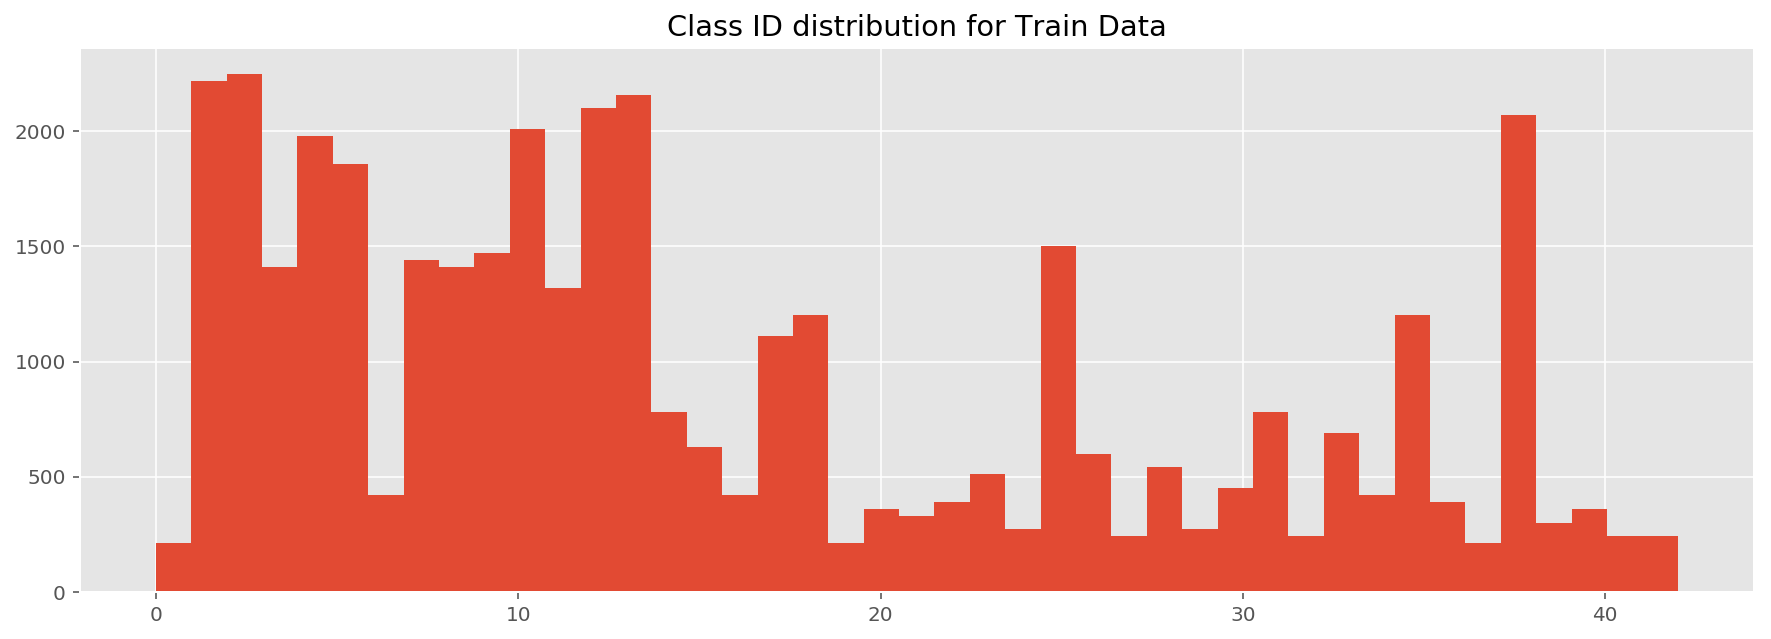

In [217]:
show_class_distribution(train_df['ClassId'], 'Train Data')

In [218]:
TEST_IMAGE_DIR = 'GTSRB\\Final_Test\\Images'

test_df = pd.read_csv(os.path.join(TEST_IMAGE_DIR, 'GT-final_test.csv'), sep=';')
test_df['Filename'] = test_df['Filename'].apply(lambda x: os.path.join(TEST_IMAGE_DIR, x))
test_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,GTSRB\Final_Test\Images\00000.ppm,53,54,6,5,48,49,16
1,GTSRB\Final_Test\Images\00001.ppm,42,45,5,5,36,40,1
2,GTSRB\Final_Test\Images\00002.ppm,48,52,6,6,43,47,38
3,GTSRB\Final_Test\Images\00003.ppm,27,29,5,5,22,24,33
4,GTSRB\Final_Test\Images\00004.ppm,60,57,5,5,55,52,11


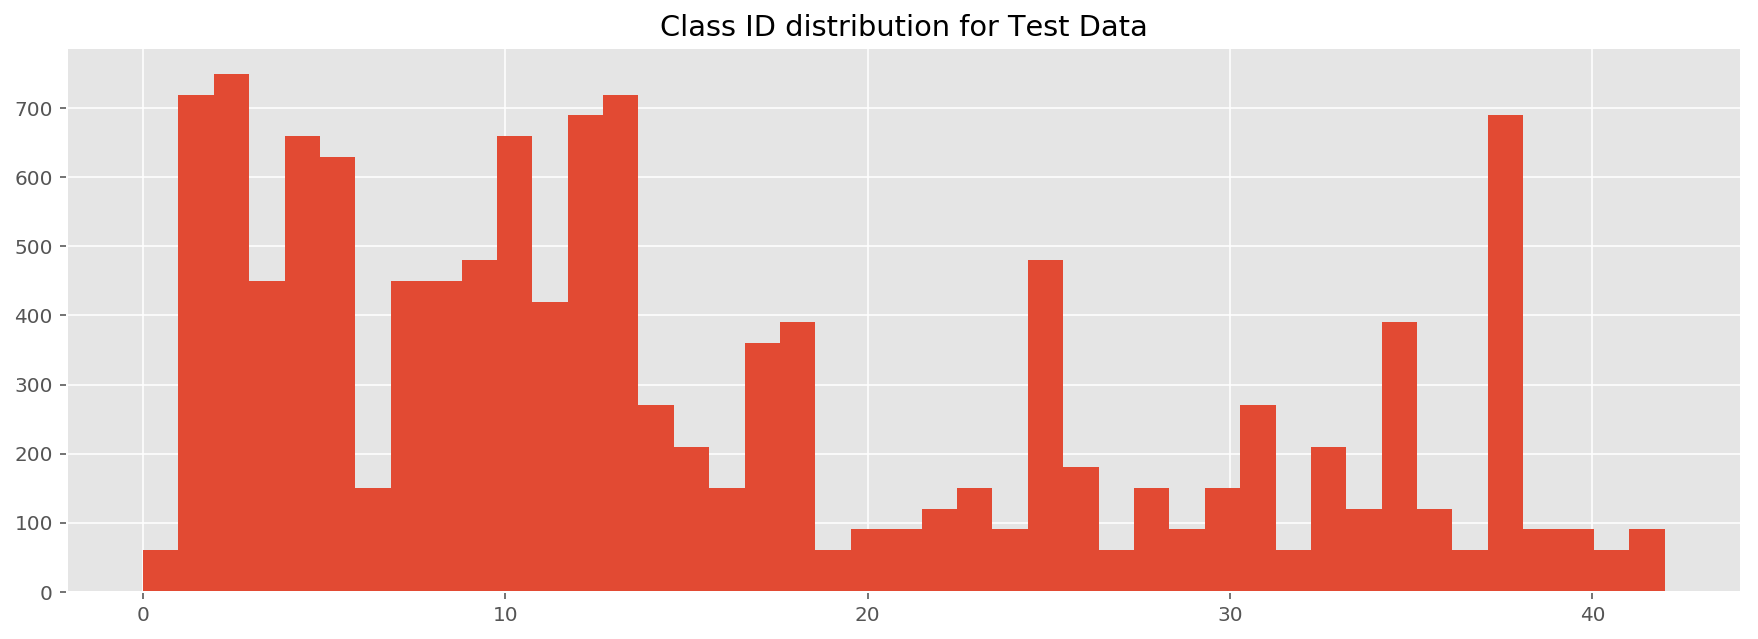

In [219]:
show_class_distribution(test_df['ClassId'], 'Test Data')

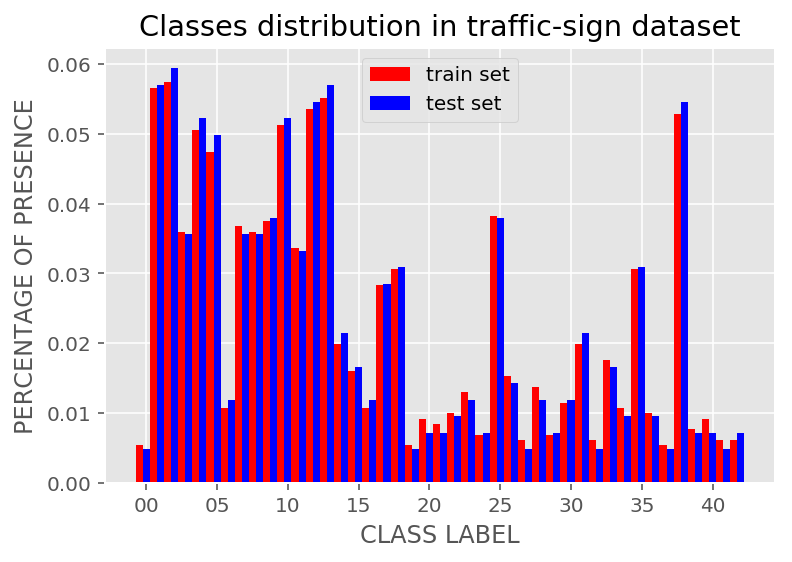

In [220]:
train_distribution, test_distribution = np.zeros(N_CLASSES), np.zeros(N_CLASSES)
for c in range(N_CLASSES):
    train_distribution[c] = np.sum(train_df['ClassId'] == c) / train_df.shape[0]
    test_distribution[c] = np.sum(test_df['ClassId'] == c) / test_df.shape[0]
fig, ax = plt.subplots()
col_width = 0.5
bar_train = ax.bar(np.arange(N_CLASSES), train_distribution, width=col_width, color='r')
bar_test = ax.bar(np.arange(N_CLASSES)+col_width, test_distribution, width=col_width, color='b')
ax.set_ylabel('PERCENTAGE OF PRESENCE')
ax.set_xlabel('CLASS LABEL')
ax.set_title('Classes distribution in traffic-sign dataset')
ax.set_xticks(np.arange(0, N_CLASSES, 5)+col_width)
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, N_CLASSES, 5)])
ax.legend((bar_train[0], bar_test[0]), ('train set', 'test set'))
plt.show()

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [221]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = train_df.shape[0]

# TODO: Number of validation examples
n_validation = int(train_df.shape[0] * 0.2)

# TODO: Number of testing examples.
n_test = test_df.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = 32*32

# TODO: How many unique classes/labels there are in the dataset.
n_classes = N_CLASSES

print("Number of training examples =", n_train)
print("Number of val examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of val examples = 7841
Number of testing examples = 12630
Image data shape = 1024
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [222]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [224]:
def get_sign_names():
    filename = 'C:\\Users\\petrush\\Documents\\Python Scripts\\Project 2\\CarND-Traffic-Sign-Classifier-Project-master\\signnames.csv'
    
    signnames_df = pd.read_csv(filename, index_col='ClassId')
    sign_names = []
    #print(signnames_df.columns)
    for name in signnames_df['SignName']:
        sign_names.append(name)
    
    return sign_names
    
sign_names = get_sign_names()
print(sign_names[2])

Speed limit (50km/h)


In [225]:
def get_samples(image_data, num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        image_data = image_data[image_data['ClassId']==class_id]
    indices = np.random.choice(image_data.shape[0], size=num_samples, replace=False)
    return image_data.iloc[indices][['Filename', 'ClassId']].values

In [226]:
def show_images(image_data, cols=5, sign_names=None, show_shape=False, func=None):
    """
    Given a list of image file paths, load images and show them.
    """
    num_images = len(image_data)
    print(num_images)
    rows = num_images//cols
    plt.figure(figsize=(cols*3,rows*2.5))
    for i, (image_file, label) in enumerate(image_data):
        image = plt.imread(image_file)
        if func is not None:
            image = func(image)
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        if sign_names is not None:
            plt.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='c', fontsize=8)        
        if show_shape:
            plt.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        
        plt.xticks([])
        plt.yticks([])
    plt.show()

X.shape =  (10, 2) [['GTSRB\\Final_Training\\Images\\00004\\00055_00007.ppm' 4]
 ['GTSRB\\Final_Training\\Images\\00009\\00047_00020.ppm' 9]
 ['GTSRB\\Final_Training\\Images\\00025\\00004_00020.ppm' 25]
 ['GTSRB\\Final_Training\\Images\\00005\\00008_00000.ppm' 5]
 ['GTSRB\\Final_Training\\Images\\00007\\00005_00001.ppm' 7]
 ['GTSRB\\Final_Training\\Images\\00004\\00005_00001.ppm' 4]
 ['GTSRB\\Final_Training\\Images\\00001\\00022_00010.ppm' 1]
 ['GTSRB\\Final_Training\\Images\\00015\\00012_00020.ppm' 15]
 ['GTSRB\\Final_Training\\Images\\00033\\00009_00016.ppm' 33]
 ['GTSRB\\Final_Training\\Images\\00004\\00036_00028.ppm' 4]]
10


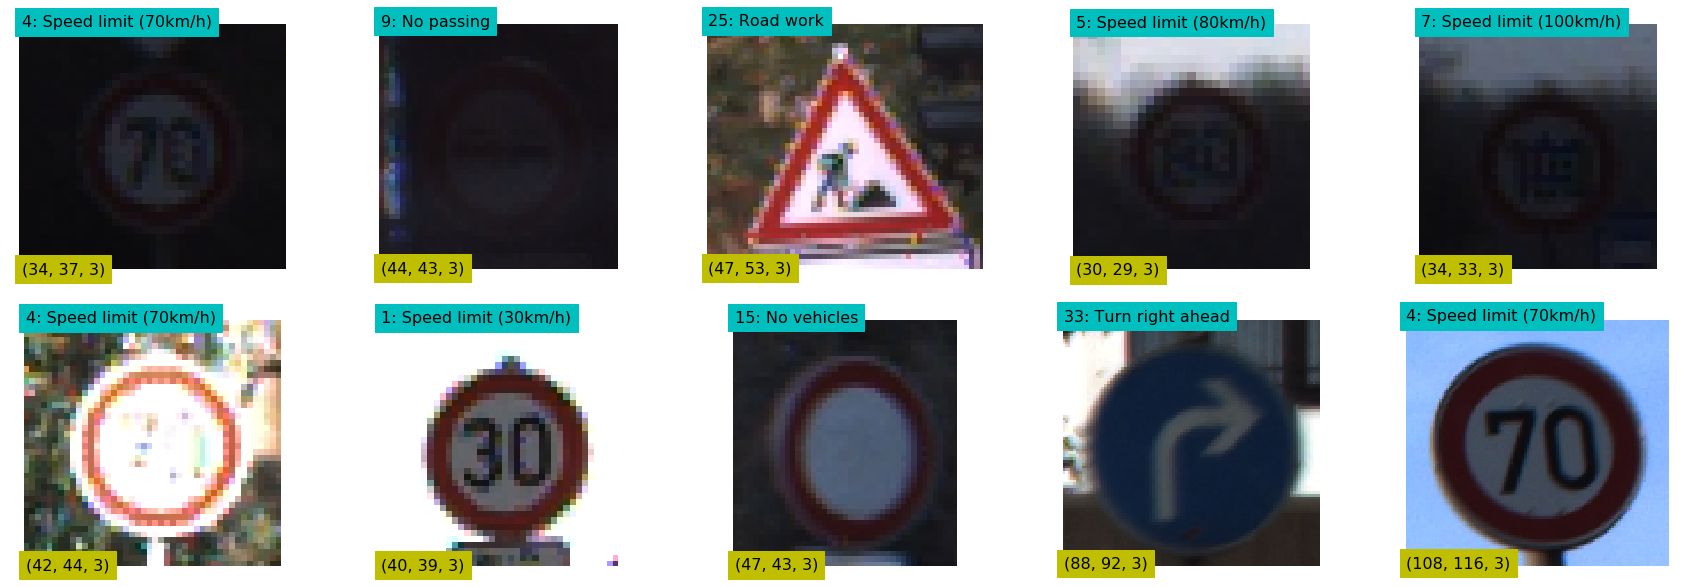

In [268]:
X = get_samples(train_df, 10)
print("X.shape = ", X.shape, X)
show_images(X, sign_names=sign_names, show_shape=True)

In [261]:
X = train_df['Filename'].values
y = train_df['ClassId'].values

print(len(X), X[0], y[0])

39209 GTSRB\Final_Training\Images\00000\00000_00000.ppm 0


In [229]:
INPUT_SHAPE = (32, 32, 3)

X_tr_names, y_train = shuffle(X, y)

X_tr_names, X_val_names, y_train, y_val = train_test_split(X_tr_names, y_train, test_size=0.2, random_state=0)
X_train = []
X_val = []
for img in X_tr_names:
    X_train.append(cv2.resize(plt.imread(img), INPUT_SHAPE[:2]))
for img in X_val_names:
    X_val.append(cv2.resize(plt.imread(img), INPUT_SHAPE[:2]))

X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
print("X_train ", (X_train.shape))
print("X_val ", (X_val.shape))

X_train  (31367, 32, 32, 3)
X_val  (7842, 32, 32, 3)


In [230]:
X_t = test_df['Filename'].values
y_t = test_df['ClassId'].values

print(len(X_t), X_t[0], y_t[0])

X_test = []
for img in X_t:
    X_test.append(cv2.resize(plt.imread(img), INPUT_SHAPE[:2]))

X_test = np.asarray(X_test)
print("X_test ", (X_test.shape))

12630 GTSRB\Final_Test\Images\00000.ppm 16
X_test  (12630, 32, 32, 3)


In [231]:
y_test = y_t

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [232]:
def preprocess(X, hist=False, normalize=False):
    X = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY), axis=2) for rgb_img in X])
    if hist == True:
        X = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), axis=2) for img in X])
    if normalize == True:
        X = (X - np.mean(X)) / np.std(X)
    return X

In [233]:
X_train_gray = preprocess(X_train, True, True)
X_val_gray = preprocess(X_val, True, True)
print("X_train_gray.shape = ", X_train_gray.shape)
print("X_val_gray.shape = ", X_val_gray.shape)

X_train_gray.shape =  (31367, 32, 32, 1)
X_val_gray.shape =  (7842, 32, 32, 1)


In [234]:
X_test_gray = preprocess(X_test, True, True)

print(X_train_gray.shape, np.mean(X_train_gray))
print(X_val_gray.shape, np.mean(X_val_gray))
print(X_test_gray.shape, np.mean(X_test_gray))

(31367, 32, 32, 1) -1.49653759734e-16
(7842, 32, 32, 1) 1.6182788907e-16
(12630, 32, 32, 1) -8.04757861476e-18


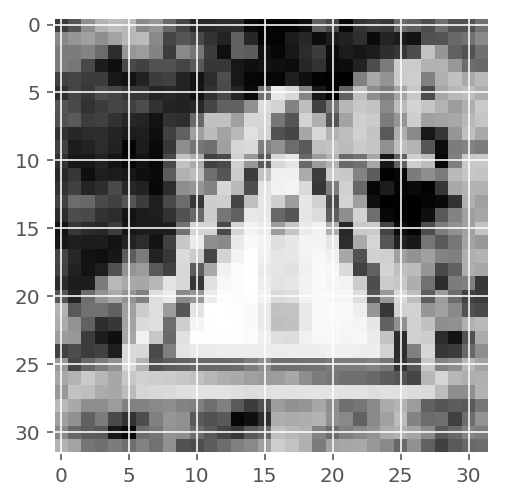

In [235]:
plt.imshow(X_train_gray[1].squeeze(), cmap='gray')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# split into train and validation
#VAL_RATIO = 0.2
#X_train_norm, X_val_norm, y_train, y_val = train_test_split(X_train_norm, y_train, test_size=VAL_RATIO, random_state=0)


# create the generator to perform online data augmentation
image_datagen = ImageDataGenerator(rotation_range=15.,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

# take a random image from the training set
img_rgb = X_train[0]

# plot the original image
plt.figure(figsize=(1,1))
plt.imshow(img_rgb)
plt.title('Example of RGB image (class = {})'.format(y_train[0]))
plt.show()

# plot some randomly augmented images
rows, cols = 4, 10
fig, ax_array = plt.subplots(rows, cols)
for ax in ax_array.ravel():
    augmented_img, _ = image_datagen.flow(np.expand_dims(img_rgb, 0), y_train[0:1]).next()
    ax.imshow(np.uint8(np.squeeze(augmented_img)))
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.suptitle('Random examples of data augmentation (starting from the previous image)')
plt.show()

### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [294]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 1])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

#saver = tf.train.Saver()

# define model
def complex_model(X, classes):
    # setup variables
    """Wconv1 = tf.get_variable("Wconv1", shape=[3, 3, 3, 64])
    bconv1 = tf.get_variable("bconv1", shape=[64])
    Wconv2 = tf.get_variable("Wconv2", shape=[3, 3, 64, 128])
    bconv2 = tf.get_variable("bconv2", shape=[128])

    W1 = tf.get_variable("W1", shape=[8*8*128+16*16*64, 64])
    b1 = tf.get_variable("b1", shape=[64])
    W2 = tf.get_variable("W2", shape=[64, 43])
    b2 = tf.get_variable("b2", shape=[43])"""
    
    Wconv1 = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=0, stddev=0.1), name='Wconv1')
    bconv1 = tf.Variable(tf.constant(0.1, shape=(6,)), name='bconv1')
    Wconv2 = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=0, stddev=0.1), name='Wconv2')
    bconv2 = tf.Variable(tf.constant(0.1, shape=(16,)))
    
    W1 = tf.Variable(tf.truncated_normal(shape=(5,5,16,400), mean=0, stddev=0.1), name='W1')
    b1 = tf.Variable(tf.constant(0.1, shape=(400,)), name='b1')
    W2 = tf.Variable(tf.truncated_normal(shape=(800, classes), mean=0, stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1, shape=(classes,)))
    
    
    print(W1.shape)

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    print("h1.shape: ", h1.shape)
    pool1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    print("pool1.shape: ", pool1.shape)
    drop1 = tf.nn.dropout(pool1, keep_prob=keep_prob)
    #bn = tf.layers.batch_normalization(h1, axis=3)
    #bn1 = batch_norm(h1, 32, is_training)
    print(drop1.shape, Wconv2.shape, bconv2.shape)
    a2 = tf.nn.conv2d(drop1, Wconv2, strides=[1,1,1,1], padding='VALID') + bconv2
    h2 = tf.nn.relu(a2)
    pool2 = tf.nn.max_pool(h2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    print("pool2.shape: ", pool2.shape)
    drop2 = tf.nn.dropout(pool2, keep_prob=keep_prob)
    
    a3 = tf.nn.conv2d(drop2, W1, strides=[1,1,1,1], padding='VALID') + b1
    h3 = tf.nn.relu(a3)
    
    
    #bn2 = batch_norm(h2, 64, is_training)
    fc0 = tf.concat([flatten(h3), flatten(drop2)], 1)
    print("fc0.shape: ", fc0.shape)
    
    y_out = tf.matmul(fc0, W2) + b2
    print("Logits.shape = ", y_out.shape)
    return y_out

In [295]:
lr = 0.0015
keep_prob = tf.placeholder(tf.float32)

global_step = tf.Variable(0, trainable=False)
start_lr = 0.0015
lr = tf.train.exponential_decay(start_lr, global_step, 7000, 0.5, staircase=False)

y_one_hot = tf.one_hot(y, 43)
print("y_one_hot.shape = ", y_one_hot.shape)
logits = complex_model(X, 43)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(loss=loss, global_step=global_step)

y_one_hot.shape =  (?, 43)
(5, 5, 16, 400)
h1.shape:  (?, 28, 28, 6)
pool1.shape:  (?, 14, 14, 6)
(?, 14, 14, 6) (5, 5, 6, 16) (16,)
pool2.shape:  (?, 5, 5, 16)
fc0.shape:  (?, 800)
Logits.shape =  (?, 43)


In [296]:
print(lr)

Tensor("ExponentialDecay:0", shape=(), dtype=float32)


In [297]:
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
print(correct_pred)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Tensor("Equal:0", shape=(?,), dtype=bool)


In [298]:
def evaluate(X_data, y_data, batch_size=64):
    m = X_data.shape[0]
    
    print("Evaluate on ", m, " samples")

    total_acc = 0
    
    sess = tf.get_default_session()
    for offset in range(0, m, batch_size):
        batch_x, batch_y = X_data[offset: offset+batch_size], y_data[offset: offset+batch_size]
        acc = sess.run(accuracy, feed_dict={X: batch_x, y: batch_y, keep_prob: 1.0})
        total_acc += acc * len(batch_x)
        
    return total_acc / m

In [299]:
num_epoch = 50
batch_size = 128
batches_per_epoch = 1000

saver = tf.train.Saver()

In [ ]:
image_datagen.fit(X_train_norm)

In [ ]:
i = 0
for batch_x, batch_y in image_datagen.flow(X_train_norm, y_train, batch_size=batch_size):
    print(i, batch_x.shape)
    i = i + 1

In [ ]:
train_acc = []
val_acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        print("Epoch {} ".format(epoch + 1))
        
        batch_counter = 0
        for batch_x, batch_y in image_datagen.flow(X_train_norm, y_train, batch_size=batch_size):
            #print(batch_y[0])
            batch_counter = batch_counter + 1
            sess.run(train_step, feed_dict={X: batch_x, y: batch_y, keep_prob: 0.5})
            #print("Batch #", batch_counter)
            if batch_counter == batches_per_epoch:
                break
            
        train_acc.append(evaluate(X_train_norm, y_train))
        print("Training accuracy: ", train_acc[-1])
        val_acc.append(evaluate(X_val_norm, y_val))
        print("Validation accuracy: ", val_acc[-1])
        
        print("Train accuracy = {:.3f}      Validation accuracy = {:.3f}".format(train_acc[-1], val_acc[-1]))
        
        #checkpointer.save(sess, save_path="C:\\Users\\petrush\\Documents\\Python Scripts\\Project 2\\CarND-Traffic-Sign-Classifier-Project-master", global_step=epoch)

In [300]:
train_acc = []
val_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    m = X_train_gray.shape[0]
    print("Train samples = ", m)
    iteration = 0
    for epoch in range(num_epoch):
        print("Epoch {} \nIter = {}".format(epoch + 1, iteration))
        #print(lr)
        
        X_train_gray, y_train = shuffle(X_train_gray, y_train)
        
        for offset in range(0, m, batch_size):
            batch_x, batch_y = X_train_gray[offset: offset+batch_size], y_train[offset: offset+batch_size]
            
            sess.run(train_step, feed_dict={X: batch_x, y: batch_y, keep_prob: 0.5})
            
            iteration = iteration + 1
            
        train_acc.append(evaluate(X_train_gray, y_train))
        #print("Training accuracy: ", train_acc[-1])
        val_acc.append(evaluate(X_val_gray, y_val))
        #print("Validation accuracy: ", val_acc[-1])
        
        print("Train accuracy = {:.3f}      Validation accuracy = {:.3f}".format(train_acc[-1], val_acc[-1]))
        
        saver.save(sess, save_path='C:\\Users\\petrush\\Documents\\Python Scripts\\Project 2\\CarND-Traffic-Sign-Classifier-Project-master\\model\\model.ckpt', global_step=epoch)

Train samples =  31367
Epoch 1 
Iter = 0
Evaluate on  31367  samples
Evaluate on  7842  samples
Train accuracy = 0.782      Validation accuracy = 0.785
Epoch 2 
Iter = 246
Evaluate on  31367  samples
Evaluate on  7842  samples
Train accuracy = 0.879      Validation accuracy = 0.872
Epoch 3 
Iter = 492
Evaluate on  31367  samples
Evaluate on  7842  samples
Train accuracy = 0.911      Validation accuracy = 0.908
Epoch 4 
Iter = 738
Evaluate on  31367  samples
Evaluate on  7842  samples
Train accuracy = 0.919      Validation accuracy = 0.915
Epoch 5 
Iter = 984
Evaluate on  31367  samples
Evaluate on  7842  samples
Train accuracy = 0.935      Validation accuracy = 0.927
Epoch 6 
Iter = 1230
Evaluate on  31367  samples
Evaluate on  7842  samples
Train accuracy = 0.952      Validation accuracy = 0.948
Epoch 7 
Iter = 1476
Evaluate on  31367  samples
Evaluate on  7842  samples
Train accuracy = 0.956      Validation accuracy = 0.948
Epoch 8 
Iter = 1722
Evaluate on  31367  samples
Evaluate on

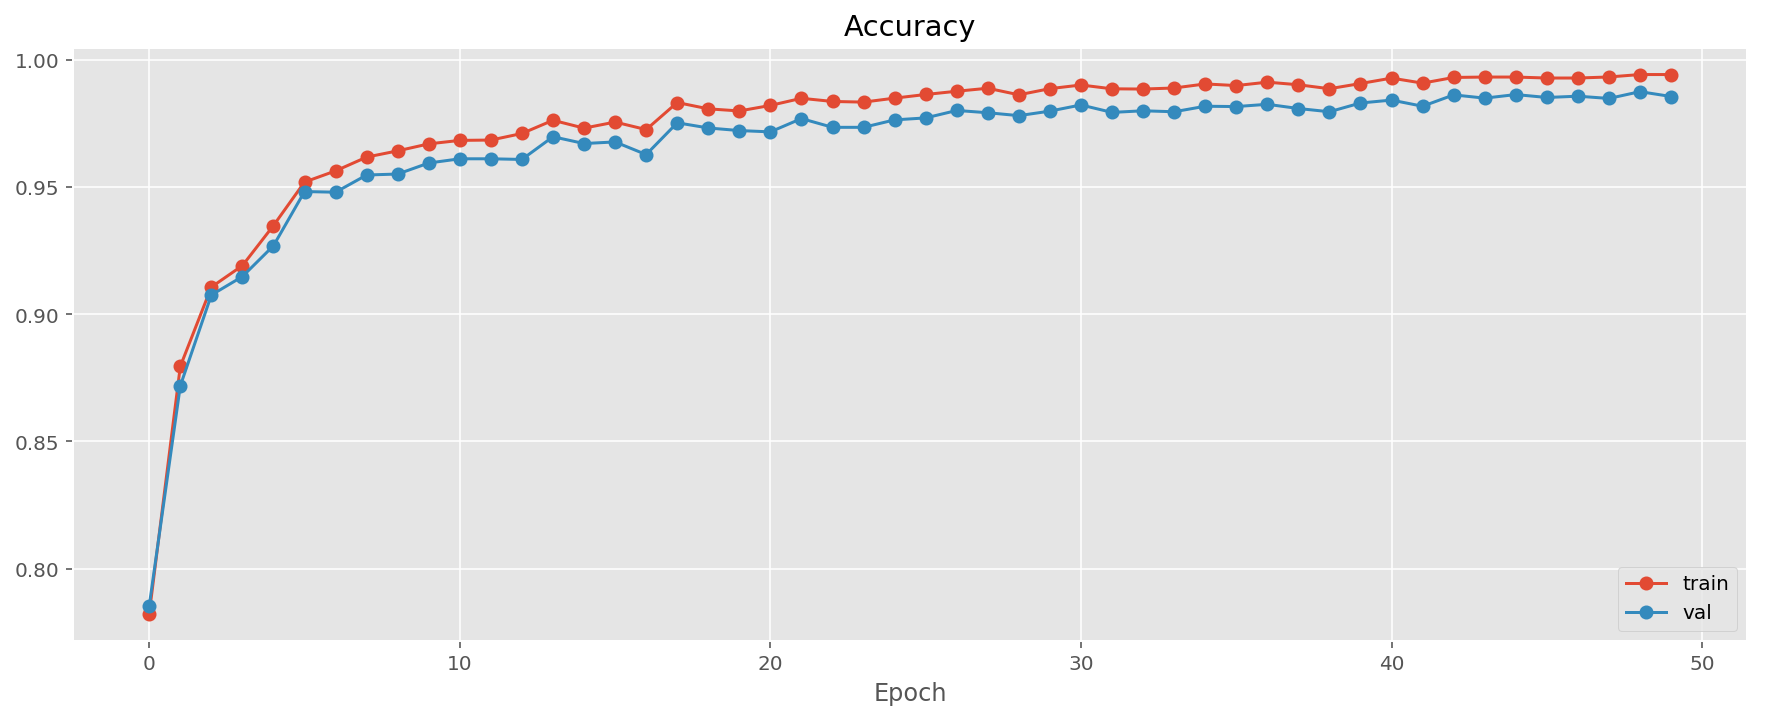

In [301]:
plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(train_acc, '-o', label='train')
plt.plot(val_acc, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [302]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
test_acc = 0

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'C:\\Users\\petrush\\Documents\\Python Scripts\\Project 2\\CarND-Traffic-Sign-Classifier-Project-master\\model\\model.ckpt-48')
    m = X_test_gray.shape[0]
    print("Test samples = ", m)
    test_acc = evaluate(X_test_gray, y_test)
    
    print("Test accuracy = {:.3f}".format(test_acc))

INFO:tensorflow:Restoring parameters from C:\Users\petrush\Documents\Python Scripts\Project 2\CarND-Traffic-Sign-Classifier-Project-master\model\model.ckpt-48
Test samples =  12630
Evaluate on  12630  samples
Test accuracy = 0.925


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [410]:
test_img = []
test_img_rgb = []
for img in glob.glob(os.path.join('C:\\Users\\petrush\\Documents\\Python Scripts\\Project 2\\CarND-Traffic-Sign-Classifier-Project-master\\examples\\new', '*.*')):
    test_img_rgb.append(cv2.resize(plt.imread(img, 0), (32, 32)))
    #print(test_img[-1].shape)

test_img = np.asarray(test_img_rgb)
test_img = preprocess(test_img_rgb, True, True)

test_img = np.asarray(test_img)

In [411]:
labels = [35, 9, 0, 27, 30, 34, 40, 7, 5]

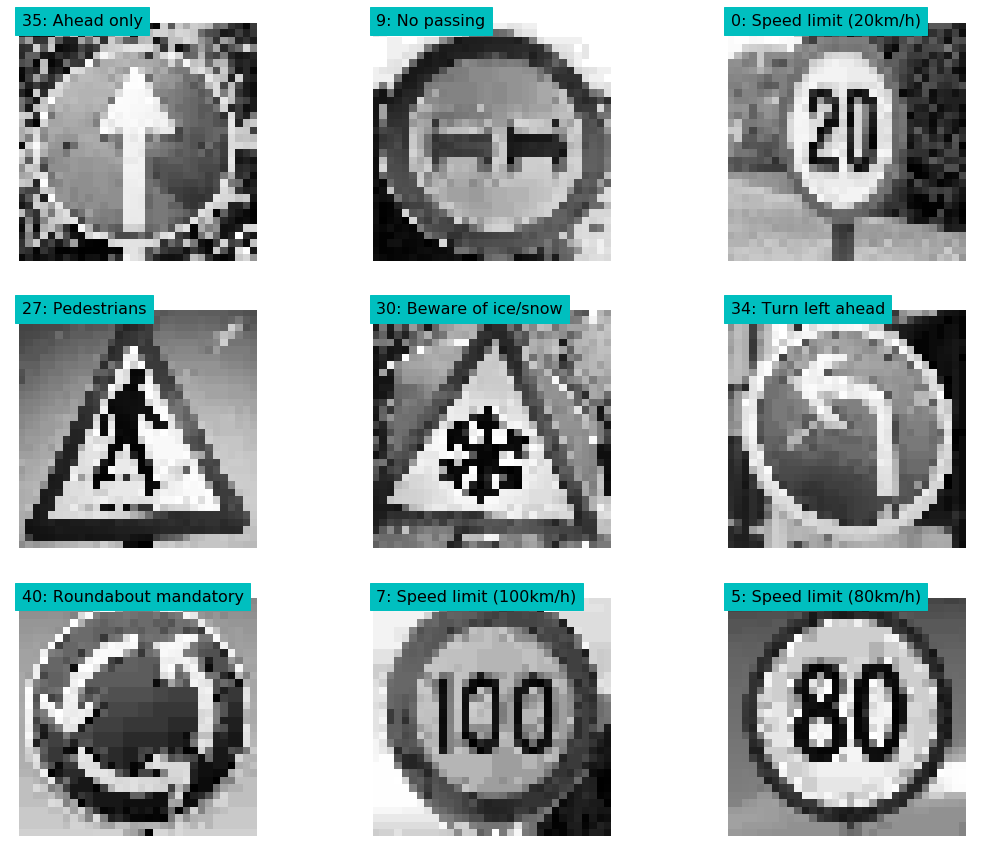

In [412]:
n = len(test_img)
rows = n//3
plt.figure(figsize=(3*3,rows*2.5))
for i, image in enumerate(test_img):
    plt.subplot(rows, 3, i+1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.text(0, 0, '{}: {}'.format(labels[i], sign_names[labels[i]]), color='k',backgroundcolor='c', fontsize=8)
    plt.xticks([])
    plt.yticks([])
plt.show()

### Predict the Sign Type for Each Image

In [413]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [414]:
prob = []
with tf.Session() as sess:
    saver.restore(sess, 'C:\\Users\\petrush\\Documents\\Python Scripts\\Project 2\\CarND-Traffic-Sign-Classifier-Project-master\\model\\model.ckpt-48')
    score = sess.run(logits, feed_dict={X: test_img, keep_prob: 1.0})
    prob = sess.run(tf.nn.softmax(score))
    predict = np.argmax(np.array(prob), axis=1)
    
print("Test accuracy = ", predict)

INFO:tensorflow:Restoring parameters from C:\Users\petrush\Documents\Python Scripts\Project 2\CarND-Traffic-Sign-Classifier-Project-master\model\model.ckpt-48
Test accuracy =  [35  9  0 28 28 34 40  8  2]


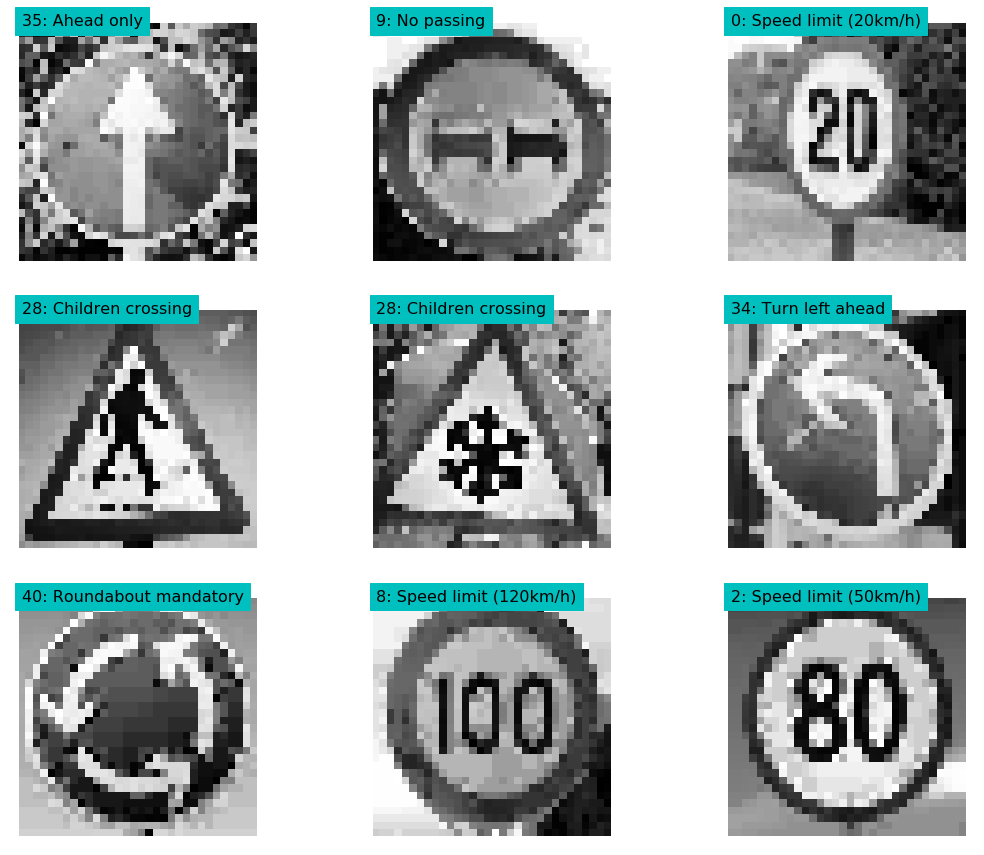

In [415]:
n = len(test_img)
rows = n//3
plt.figure(figsize=(3*3,rows*2.5))
for i, image in enumerate(test_img):
    plt.subplot(rows, 3, i+1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.text(0, 0, '{}: {}'.format(predict[i], sign_names[predict[i]]), color='k',backgroundcolor='c', fontsize=8)
    plt.xticks([])
    plt.yticks([])
plt.show()

### Analyze Performance

In [416]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [417]:
print(100 * sum(predict == labels) / len(labels), '%')

55.5555555556 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [418]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [419]:
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(prob), k=5))



Ahead only  =  99.9713122845 %
Yield  =  0.0140838485095 %
Go straight or right  =  0.00771069826442 %
Turn left ahead  =  0.00369423905795 %
Road work  =  0.00148691606228 %


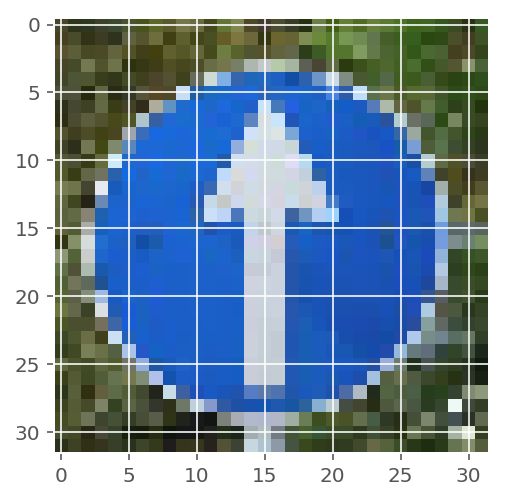

In [422]:
plt.imshow(test_img_rgb[0])
for (i, prob) in zip(top5[1][0], top5[0][0]):
    print(sign_names[i], ' = ', 100*prob, '%')

No passing  =  98.2276380062 %
End of no passing  =  1.77098643035 %
No passing for vehicles over 3.5 metric tons  =  0.00132961231429 %
Priority road  =  2.373631105e-05 %
Vehicles over 3.5 metric tons prohibited  =  1.21606532844e-05 %


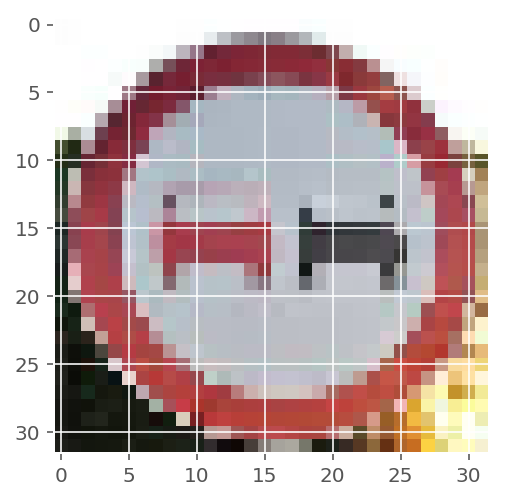

In [423]:
plt.imshow(test_img_rgb[1])
for (i, prob) in zip(top5[1][1], top5[0][1]):
    print(sign_names[i], ' = ', 100*prob, '%')

Speed limit (20km/h)  =  35.9133541584 %
Roundabout mandatory  =  21.02124542 %
Speed limit (60km/h)  =  13.5746866465 %
Speed limit (30km/h)  =  6.29437193274 %
Speed limit (100km/h)  =  4.49141412973 %


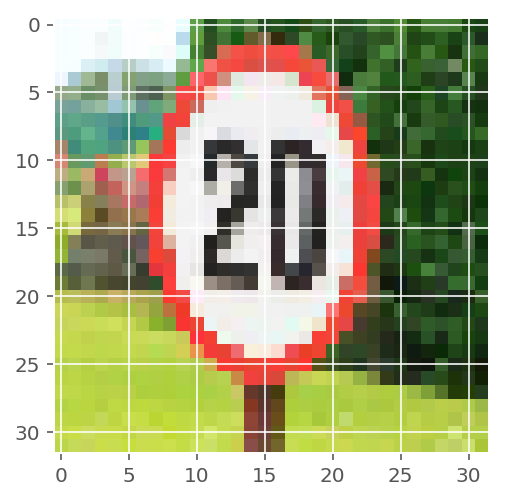

In [424]:
plt.imshow(test_img_rgb[2])
for (i, prob) in zip(top5[1][2], top5[0][2]):
    print(sign_names[i], ' = ', 100*prob, '%')

Children crossing  =  42.4566119909 %
Traffic signals  =  21.0687920451 %
Right-of-way at the next intersection  =  6.18942342699 %
Roundabout mandatory  =  5.84093555808 %
Dangerous curve to the right  =  5.66274113953 %


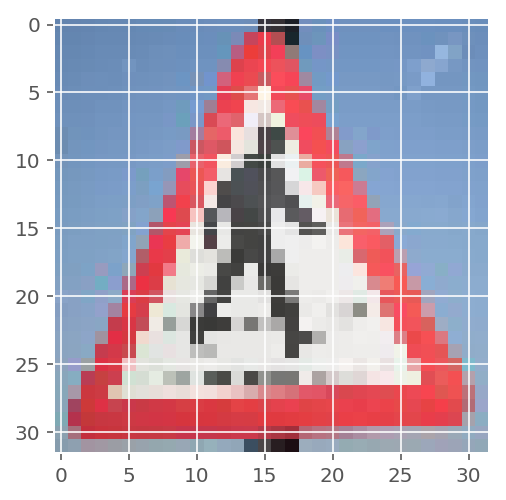

In [425]:
plt.imshow(test_img_rgb[3])
for (i, prob) in zip(top5[1][3], top5[0][3]):
    print(sign_names[i], ' = ', 100*prob, '%')

Children crossing  =  84.952300787 %
Beware of ice/snow  =  7.71533697844 %
Road work  =  3.05955298245 %
Right-of-way at the next intersection  =  1.96705535054 %
Priority road  =  0.527823716402 %


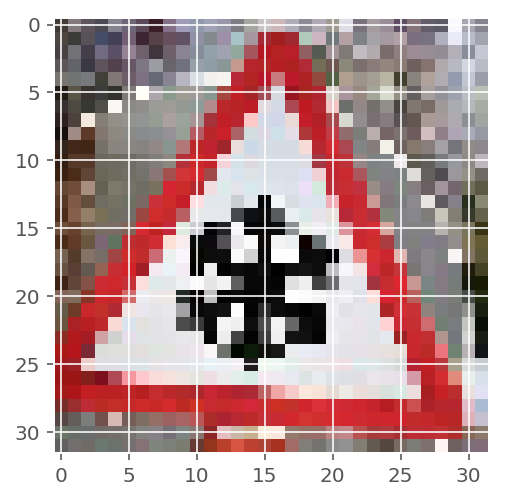

In [426]:
plt.imshow(test_img_rgb[4])
for (i, prob) in zip(top5[1][4], top5[0][4]):
    print(sign_names[i], ' = ', 100*prob, '%')

Turn left ahead  =  99.5821237564 %
Keep right  =  0.40505179204 %
Priority road  =  0.00554334037588 %
Ahead only  =  0.00519281675224 %
Speed limit (60km/h)  =  0.000606551157034 %


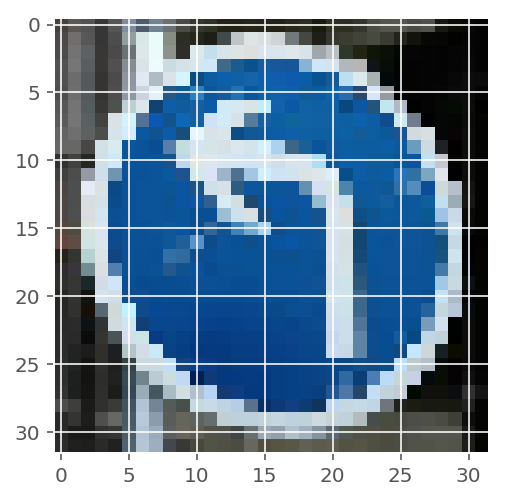

In [427]:
plt.imshow(test_img_rgb[5])
for (i, prob) in zip(top5[1][5], top5[0][5]):
    print(sign_names[i], ' = ', 100*prob, '%')

Roundabout mandatory  =  92.2083258629 %
Priority road  =  7.75479152799 %
Speed limit (100km/h)  =  0.0207777600735 %
Speed limit (120km/h)  =  0.00648313798592 %
Stop  =  0.00196395485546 %


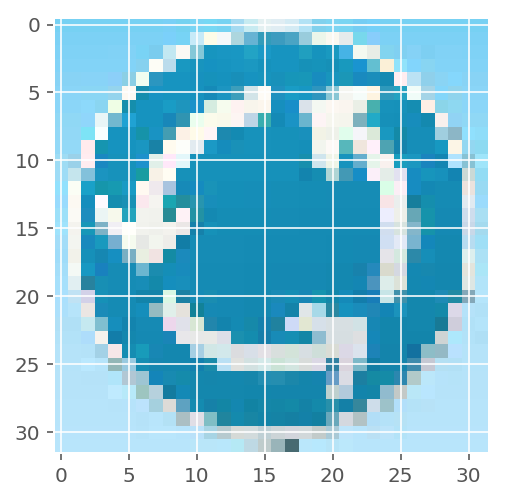

In [428]:
plt.imshow(test_img_rgb[6])
for (i, prob) in zip(top5[1][6], top5[0][6]):
    print(sign_names[i], ' = ', 100*prob, '%')

Speed limit (120km/h)  =  47.0792651176 %
Speed limit (100km/h)  =  37.836548686 %
Speed limit (50km/h)  =  5.24839647114 %
Roundabout mandatory  =  3.42317596078 %
Speed limit (30km/h)  =  1.73508301377 %


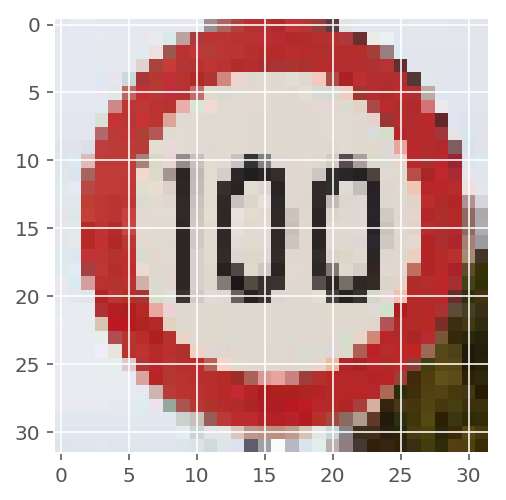

In [429]:
plt.imshow(test_img_rgb[7])
for (i, prob) in zip(top5[1][7], top5[0][7]):
    print(sign_names[i], ' = ', 100*prob, '%')

Speed limit (50km/h)  =  60.1261138916 %
Speed limit (30km/h)  =  34.1817259789 %
End of speed limit (80km/h)  =  2.86218095571 %
Speed limit (80km/h)  =  2.38122455776 %
Speed limit (60km/h)  =  0.238916417584 %


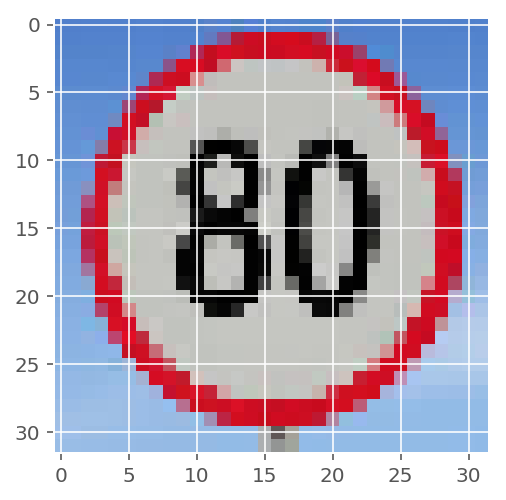

In [430]:
plt.imshow(test_img_rgb[8])
for (i, prob) in zip(top5[1][8], top5[0][8]):
    print(sign_names[i], ' = ', 100*prob, '%')

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")